In [103]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import sep
import photutils

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)

from astropy import wcs
from astropy.io import fits
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Increase the pixel stack for large image
sep.set_extract_pixstack(1000000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# Some useful functions from my code

from kungpao import io
from kungpao.galsbp import galSBP
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

In [4]:
# Convolution kernel I used for detecting objects on the image

kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

# Directions to my IRAF executbles
ISO = '/Users/song/iraf/extern/stsdas/bin.macosx/x_isophote.e'
TBL = '/Users/song/iraf/extern/tables/bin.macosx/x_ttools.e'

## Inspect the image

In [23]:
img_dir = '/Users/song/Dropbox/final-images-1/'

# One of my favorite galaxies of all time
hdr_test = fits.open(os.path.join(img_dir, 'M104subsky12.fits'))[0].header
img_test = fits.open(os.path.join(img_dir, 'M104subsky12.fits'))[0].data

# For running sep
img_test = img_test.byteswap().newbyteorder()

img_w, img_h = img_test.shape

In [19]:
# I just realize that these images do not have WCS information in the header.  
# It would be useful to have these information available 

wcs_test = wcs.WCS(hdr_test)

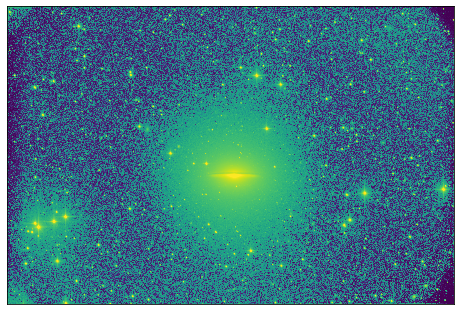

In [27]:
_ = display_single(img_test, contrast=0.2, scale_bar=None)

## Image reduction 

### Measure and subtract a background to remove low-frequency structures

* This will remove part of the extended halo.  The purpose is to reduce the difficulty of source detection and deblending

# Mean Sky / RMS Sky =    1.72370 /   14.24700


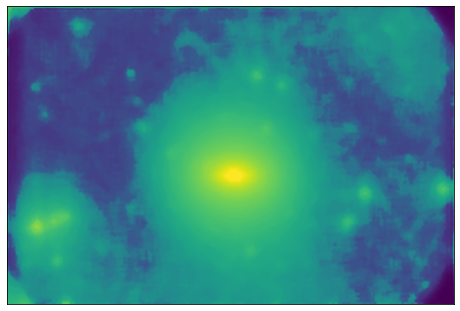

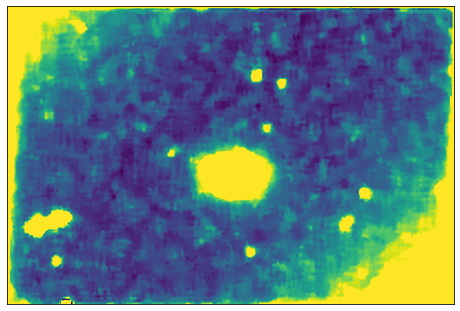

In [30]:
bkg_local = sep.Background(img_test, bw=20, bh=20, fw=4, fh=4)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_local.globalback, bkg_local.globalrms))

_ = display_single(bkg_local.back(), contrast=0.5, scale_bar=None)


# The RMS map will be used as the image error for object detection 
_ = display_single(bkg_local.rms(), contrast=0.5, scale_bar=None)

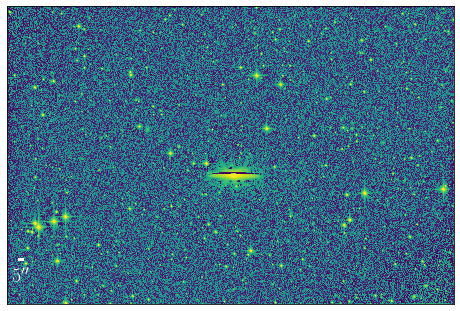

In [31]:
# Subtract the very "local" sky background
img_subbkg = img_test - bkg_local.back()

# As you can see, most of the extended structures have been subtracted off.
_ = display_single(img_subbkg, contrast=0.3)

### Detect objects to mask out

# Detect 1640 objects


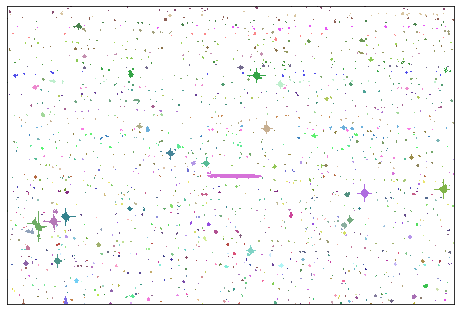

In [47]:
# Do not use very aggressive deblending to avoid breaking the main galaxy into many pieces
# Here we use a high threshold to make sure they represent the bright part of the image.
obj_hthre, seg_hthre = sep.extract(img_subbkg, 7.0,
                                   err=bkg_local.rms(), 
                                   minarea=50, 
                                   filter_kernel=kernel3,
                                   deblend_nthresh=48, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

print("# Detect %d objects" % len(obj_hthre))

_ = display_single(seg_hthre, scale='linear', cmap=SEG_CMAP)

### Remove the target or any galaxy of interest

* Normally, one can use the WCS information and the coordinate of the galaxy to do this. 
* Since there is no WCS information, you need to know where is the center of the galaxy manually from the image

In [53]:
# Rough center of the galaxy measured on the image
x_cen, y_cen = 2039, 1151

In [54]:
# Or if you know you galaxy is the brightest object on the image, you can do something like this: 

obj_bright = obj_hthre[np.argmax(obj_hthre['flux'])]
print(obj_bright['x'], obj_bright['y'])

# So, basically find the same galaxy

2039.1125325074615 1150.9399267214146


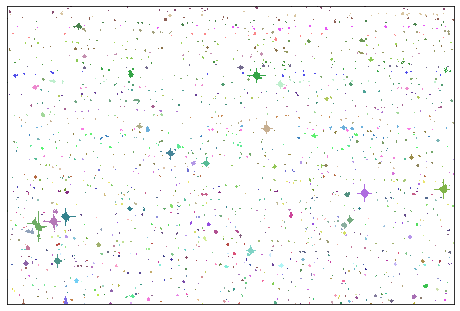

In [56]:
# Now, remove the segmentation associated with the galaxy
# Remember to reverse the order of x and y
seg_nocen = imtools.seg_remove_obj(seg_hthre, y_cen, x_cen)

_ = display_single(seg_nocen, scale='linear', cmap=SEG_CMAP)

### Making a final object mask 

* The easiest way is to just grow the size of each segement vial convolution
* You can separate the objects by type and/or brightness and/or distance to the target, and apply different convolution kernel and threshold to achieve more careful masking
* You can also include specific masks for bright stars 
    - If you have WCS information, I can easily show you how to do this through matching with GAIA catalog.

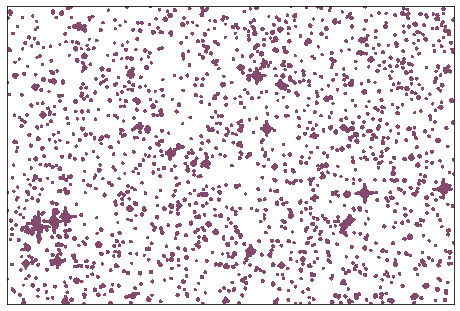

In [70]:
seg_conv = copy.deepcopy(seg_nocen)
seg_conv[seg_nocen > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 5 pixel
# This is actually pretty slow, because the image is very large. 
seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(5.0))

seg_mask = seg_conv >= 0.01

_ = display_single(seg_mask.astype(int), cmap=SEG_CMAP)

### Measure a more global background

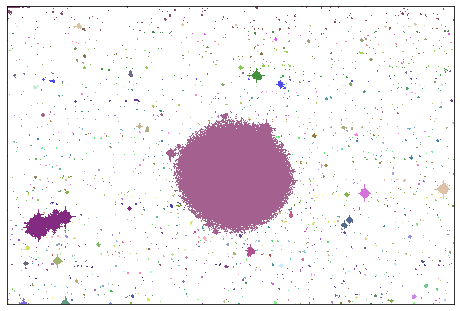

In [80]:
# Low threshold detection to make sure every object is detected
obj_lthre, seg_lthre = sep.extract(img_test - bkg_local.globalback, 3.0,
                                   err=bkg_local.globalrms, 
                                   minarea=20, 
                                   deblend_nthresh=12, deblend_cont=0.1,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

_ = display_single(seg_lthre, cmap=SEG_CMAP)

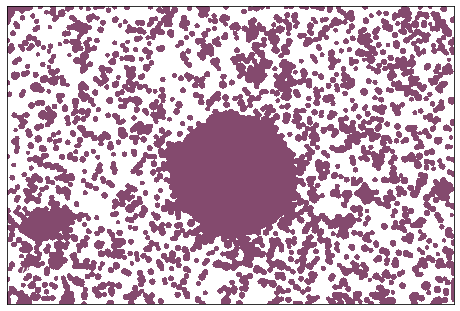

In [81]:
seg_conv = copy.deepcopy(seg_lthre)
seg_conv[seg_lthre > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 10 pixel
bkg_mask = convolve(seg_conv.astype('float'), Gaussian2DKernel(10.0))

bkg_mask = bkg_mask >= 0.005
_ = display_single(bkg_mask.astype(int), cmap=SEG_CMAP)

# Mean Sky / RMS Sky =   -0.33071 /   15.58530


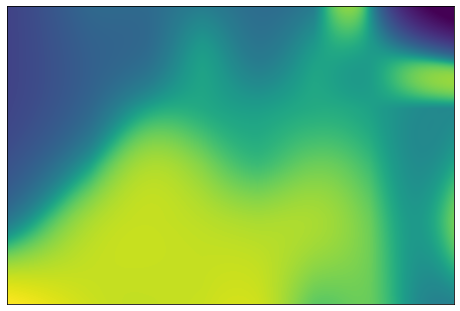

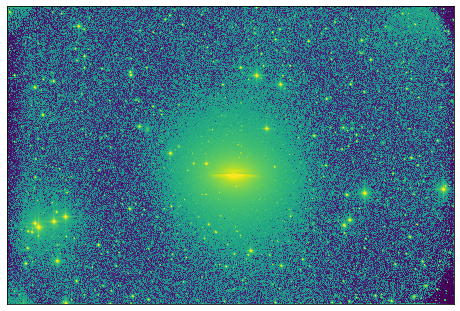

In [89]:
# If you trust your original sky subtraction, this step may not be necessary
# Here it is just for demonstration

bkg_global = sep.Background(img_test, 
                            mask=bkg_mask, maskthresh=0,
                            bw=500, bh=500, 
                            fw=50, fh=50)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_global.globalback, bkg_global.globalrms))

_ = display_single(bkg_global.back(), contrast=0.5, scale_bar=None)

img_corr = img_test - bkg_global.back()

_ = display_single(img_corr, contrast=0.3, scale_bar=None)

### Save the background subtracted image and the mask to FITS file

In [94]:
img_fits = '/Users/song/Downloads/m104_img.fits'
msk_fits = '/Users/song/Downloads/m104_msk.fits'

_ = io.save_to_fits(img_corr, img_fits)
_ = io.save_to_fits(seg_mask.astype('uint8'), msk_fits)

### Running Ellipse for 1-D profile

In [98]:
# Before runnning Ellipse, we need to know something about the galaxy 
# Centeral coordinate 
x_cen, y_cen = x_cen, y_cen

# Initial guess of axis ratio and position angle 
ba_ini, pa_ini = 0.6, 90.0

# Initial radius of Ellipse fitting
sma_ini = 10.0

# Minimum and maximum radiuse of Ellipse fitting
sma_min, sma_max = 0.0, 1000.0

# Stepsize of Ellipse fitting
# By default we are not using linear step size
step = 0.10

# Behaviour of Ellipse fitting
# Ellipse can fix certain parameters at the input values or fit everything
stage = 1    # Fit everything, let the center, shape of each isophote to be free
stage = 2    # Fix the central coordinate of every isophote at the x_cen / y_cen position
stage = 3    # Fix the central coordinate and shape of every isophote at input values
stage = 4    # This is the "force photometry" mode, need an external Ellipse output binary table as template (use `inEllip` parameter)
# Here we start with step 1
stage = 1

# Pixel scale of the image
# Used to convert the intensity into surface brightness unit
# Since we do not have WCS here, I just write down 1.0 pixel / arcsec
pix_scale = 1.0

# Photometric zeropoint 
# Used to convert the intensity into surface brightness unit
# I am not sure about the calibration details, so just put 0.0 for now
zeropoint = 0.0

# Exposure time
# Used to convert the intensity into surface brightness unit
# I assume the image is normalized into 1 sec exposure time
exptime = 1.0

# Along each isophote, Ellipse will perform sigmal clipping to remove problematic pixels
# The behaviour is decided by these three parameters: Number of sigma cliping, lower, and upper clipping threshold 
n_clip, low_clip, upp_clip = 2, 3.0, 3.0

# After the clipping, Ellipse can use the mean, median, or bi-linear interpolation of the remain pixel values
# as the "average intensity" of that isophote 
integrade_mode = 'median'   # or 'mean', or 'bi-linear'


# Start running Ellipse like this 
# Step 1 will take a long time, ~ 10 mins on my computer, you can use larger stepsize to shorten the process
ell_1, bin_1 = galSBP.galSBP(img_fits, 
                             mask=msk_fits,
                             galX=x_cen, galY=y_cen,
                             galQ=ba_ini, galPA=pa_ini,
                             iniSma=sma_ini, 
                             minSma=sma_min, maxSma=sma_max,
                             pix=pix_scale, zpPhoto=zeropoint,
                             expTime=exptime, 
                             stage=stage,
                             ellipStep=step,
                             isophote=ISO, 
                             xttools=TBL, 
                             uppClip=upp_clip, lowClip=low_clip, 
                             nClip=n_clip, 
                             maxTry=3,
                             intMode=integrade_mode, 
                             saveOut=True, plMask=True,
                             verbose=True, savePng=False, 
                             updateIntens=False)

/Users/song/Downloads/m104_msk.fits -> temp_982RQ.fits.pl
/Users/song/Downloads/m104_msk.fits -> temp_982RQ.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  2039 1151
###      galR :  20.0
###      iniSma, maxSma :  10.0 1000.0
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/song/Downloads/m104_img.fits
###      Input Image   : temp_982RQ.fits
###      Output Binary : /Users/song/Downloads/m104_img_ellip

In [100]:
# The out put file is a astropy.table

# The output binary file is at bin_1
print("# Output file: %s" % bin_1)

ell_1

# Output file: /Users/song/Downloads/m104_img_ellip_1.bin


sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,42178.07,nan,nan,nan,nan,nan,nan,nan,2039.304,nan,1157.591,nan,334.0568,nan,nan,0.0,-11.56272,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-11.562716758119453,-11.562716758119453,-11.562716758119453,42178.07,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,2039.6161172831148,1154.979489945766,0.4823894376252962,88.59243573961818,0.0,42178.07,-11.562716758119453,0.0,801.2093045826115,-21.154358992963957,-21.154358992963957,-21.154358992963957
0.5209865,42352.11,15.57981,79.44177,56.17382,0.6309919,nan,76.78014,nan,2039.304,nan,1157.591,nan,-5.173479,447.034,86.40878,0.8495846,-11.56719,0.0003991288,0.000399591,42178.07,42178.07,-11.56272,-11.56272,1.0,1.0,5.018115,433.7049,0.7189317,62.73635,3.176209,274.602,-2.220266,192.0452,13,0,1.0,4.0,187.0586,2.0,72.52216,7.81362,2.911191,7.55301,19.8286,2.673317,-11.43327,2.579436,76.78014,-11.567187629850384,-11.567187629850384,-11.567187629850384,42352.11,0.0,0.00039932964924105363,-11.567586959499625,-11.566788300201143,0.5209865,0.84958457240344,0.0,0.0,2039.6161172831148,1154.979489945766,0.4823894376252962,88.59243573961818,0.0,42352.11,-11.567187629850384,0.0,801.2093045826115,-21.154358992963957,-21.154358992963957,-21.154358992963957
0.5730851,42351.84,17.31148,88.27158,62.41743,0.6309919,nan,76.78014,nan,2039.304,nan,1157.591,nan,-6.54353,453.1766,69.25568,0.8700712,-11.56718,0.0004438452,0.000443805,42178.07,42178.07,-11.56272,-11.56272,1.0,1.0,3.847007,266.5258,0.9123476,63.5688,2.644436,183.2842,-1.750179,121.405,13,0,1.0,4.0,187.0586,2.0,79.64057,9.166303,4.754399,8.860576,23.80687,2.932164,-12.94656,2.829193,76.78014,-11.567180708124178,-11.567180708124178,-11.567180708124178,42351.84,0.0,0.0004437082363448752,-11.567624416360523,-11.566736999887834,0.5730851,0.8700711716555267,2798.529266652682,2798.529266652682,2039.6161172831148,1154.979489945766,0.4823894376252962,88.59243573961818,0.0,42351.84,-11.567180708124178,2798.529266652682,801.2093045826115,-21.154358992963957,-21.154358992963957,-21.154358992963957
0.6303936,42351.46,19.35973,98.71563,69.80249,0.6309919,nan,76.78014,nan,2039.304,nan,1157.591,nan,-7.869587,458.9731,58.32238,0.8910518,-11.56717,0.0004964231,0.0004961837,42178.07,42178.07,-11.56272,-11.56272,1.0,1.0,3.084227,179.9823,1.043515,61.14062,2.320643,135.4804,-1.463042,85.52277,13,0,1.0,4.0,187.0586,2.0,87.41491,10.8248,6.917795,10.46375,28.58355,3.27302,-14.86646,3.158079,76.78014,-11.567170966360685,-11.567170966360685,-11.567170966360685,42351.46,0.0,0.0004961991157017565,-11.567667165476387,-11.566674767244983,0.6303936,0.8910517938364548,6184.721491253753,6184.721491253753,2039.6161172831148,1154.979489945766,0.4823894376252962,88.59243573961818,0.0,42351.46,-11.567170966360685,6184.721491253753,801.2093045826115,-21.154358992963957,-21.154358992963957,-21.154358992963957
0.693433,42350.97,21.50211,109.6397,77.52697,0.630

In [105]:
# The useful information in the outputs are 
# sma:  distance along the major axis in unit of pixel 
# intens, int_err:  average intensity at different radius along the major axis and associated error 
# x0, y0, x0_err, y0_err:  central coordinates and their errors
# ell, ell_err:  ellipticity and its error
# pa, pa_err:  position angle and its error
# a3, a4, b3, b4:  amplitudes of the higher order Fourier components

# You can visualize the isophotes using 

def display_isophote(img, ell):
    """Visualize the isophotes."""
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0.0, right=1.0, 
                        bottom=0.0, top=1.0,
                        wspace=0.00, hspace=0.00)
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.0, hspace=0.00)

    # Whole central galaxy: Step 2
    ax1 = fig.add_subplot(gs[0])
    ax1.yaxis.set_major_formatter(NullFormatter())
    ax1.xaxis.set_major_formatter(NullFormatter())

    ax1 = display_single(img, ax=ax1, scale_bar=False)

    for k, iso in enumerate(ell):
        if k % 2 == 0:
            e = Ellipse(xy=(iso['x0'], iso['y0']),
                        height=iso['sma'] * 2.0,
                        width=iso['sma'] * 2.0 * (1.0 - iso['ell']),
                        angle=iso['pa'])
            e.set_facecolor('none')
            e.set_edgecolor('r')
            e.set_alpha(0.5)
            e.set_linewidth(1.5)
            ax1.add_artist(e)
    ax1.set_aspect('equal')

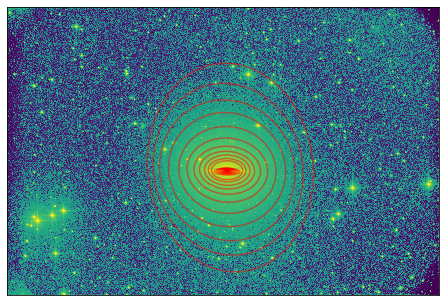

In [106]:
_ = display_isophote(img_test, ell_1)

* You can use the following functions to visualize the results in 1-D profiles

In [131]:
def display_center_fourier(ell, x_max=4.0):
    """Display the 1-D profiles."""
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.0, right=1.0, 
                        bottom=0.0, top=1.0,
                        wspace=0.00, hspace=0.00)

    ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.23])
    ax2 = fig.add_axes([0.08, 0.30, 0.85, 0.23])
    ax3 = fig.add_axes([0.08, 0.53, 0.85, 0.23])
    ax4 = fig.add_axes([0.08, 0.76, 0.85, 0.23])

    # A3 / B3 profile
    ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax1.errorbar((ell['sma'] ** 0.25), 
                 ell['a3'],
                 yerr=ell['a3_err'],
                 color='k', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    
    ax1.errorbar((ell['sma'] ** 0.25), 
                 ell['b3'],
                 yerr=ell['b3_err'],
                 color='r', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax1.set_xlim(1.09, x_max)
    ax1.set_ylim(-0.9, 0.9)

    ax1.set_xlabel(r'$R/\mathrm{pixel}^{1/4}$', fontsize=30)
    ax1.set_ylabel(r'${A_3\ {\rm or}\ B_3}$', fontsize=30)

    # A4/ B4 profile
    ax2.grid(linestyle='--', alpha=0.4, linewidth=2)
    
    ax2.errorbar((ell['sma'] ** 0.25), 
                 ell['a4'],
                 yerr=ell['a4_err'],
                 color='k', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    
    ax2.errorbar((ell['sma'] ** 0.25), 
                 ell['b4'],
                 yerr=ell['b4_err'],
                 color='r', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)

    ax2.xaxis.set_major_formatter(NullFormatter())
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax2.set_xlim(1.09, x_max)
    ax2.set_ylim(-0.9, 0.9)
    ax2.set_ylabel(r'${A_4\ {\rm or}\ B_4}$', fontsize=30)
    
    # X central coordinate profile
    ax3.grid(linestyle='--', alpha=0.4, linewidth=2)
    
    ax3.errorbar((ell['sma'] ** 0.25), 
                 ell['x0'],
                 yerr=ell['x0_err'],
                 color='k', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)
    
    ax3.xaxis.set_major_formatter(NullFormatter())
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax3.set_xlim(1.09, x_max)
    ax3.set_ylabel(r'$\mathrm{X_0}$', fontsize=32)

    # Position Angle profile
    ax4.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax4.errorbar((ell['sma'] ** 0.25), 
                 ell['y0'], yerr=ell['y0_err'],
                 color='k', alpha=0.7, fmt='o', 
                 capsize=4, capthick=2, elinewidth=2)

    ax4.xaxis.set_major_formatter(NullFormatter())
    for tick in ax4.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax4.set_xlim(1.09, x_max)
    ax4.set_ylabel(r'$\mathrm{Y_0}$', fontsize=25)
    
    return fig


def display_intensity_shape(ell, x_max=4.0):
    """Display the 1-D profiles."""
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(left=0.0, right=1.0, 
                        bottom=0.0, top=1.0,
                        wspace=0.00, hspace=0.00)

    ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.48])
    ax2 = fig.add_axes([0.08, 0.55, 0.85, 0.20])
    ax3 = fig.add_axes([0.08, 0.75, 0.85, 0.20])

    # 1-D profile
    ax1.grid(linestyle='--', alpha=0.4, linewidth=2)

    yerr = np.log10(ell['intens'] + ell['int_err']) - np.log10(ell['intens'])
    ax1.errorbar((ell['sma'] ** 0.25), 
                 np.log10(ell['intens']),
                 yerr=yerr,
                 color='k', alpha=0.7, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax1.set_xlim(1.09, x_max)

    ax1.set_xlabel(r'$R/\mathrm{pixel}^{1/4}$', fontsize=30)
    ax1.set_ylabel(r'$\log\ ({\rm Intensity})$', fontsize=30)

    # Ellipticity profile
    ax2.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax2.errorbar((ell['sma'] ** 0.25), 
                 ell['ell'],
                 yerr=ell['ell_err'],
                 color='k', alpha=0.7, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax2.xaxis.set_major_formatter(NullFormatter())
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax2.set_xlim(1.09, x_max)
    ax2.set_ylabel(r'$e$', fontsize=35)

    # Position Angle profile
    ax3.grid(linestyle='--', alpha=0.4, linewidth=2)

    ax3.errorbar((ell['sma'] ** 0.25), 
                 ell['pa'], yerr=ell['pa_err'],
                 color='k', alpha=0.7, fmt='o', capsize=4, capthick=2, elinewidth=2)

    ax3.xaxis.set_major_formatter(NullFormatter())
    for tick in ax3.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)

    ax3.set_xlim(1.09, x_max)
    ax3.set_ylabel(r'$\mathrm{PA\ [deg]}$', fontsize=25)
    
    return fig

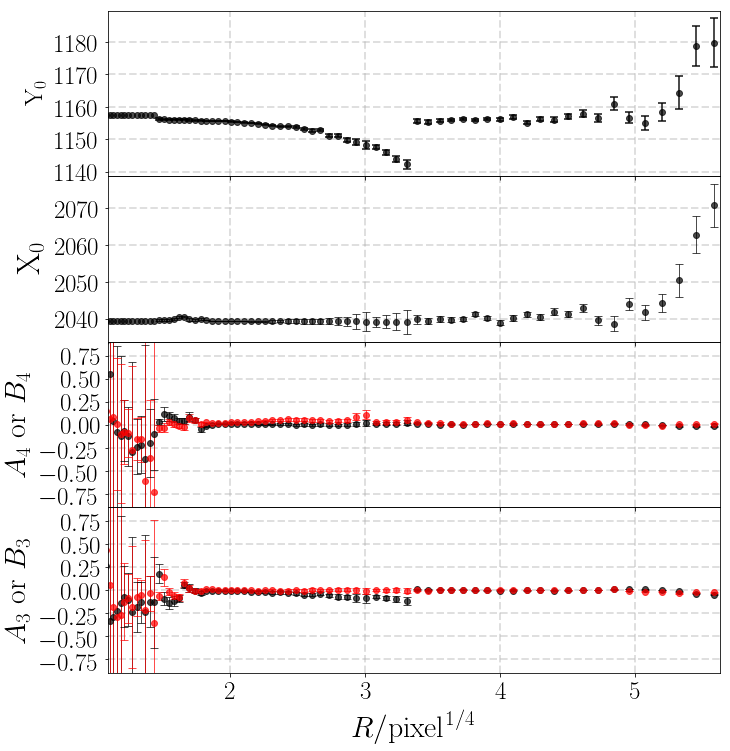

In [126]:
# First, let's see the central coordinates and the higher order shape of the isophote

# Notice that I use r^0.25 as coordinate, you can also use linear for disk galaxy or using log10(r)

# Sudden change of central coordinates and higher order shape can hint significant structural change 
# e.g. impact of dust lane, transition from disk to bulge, overall asymmetric, etc.

_ = display_center_fourier(ell_1, x_max=(1000 ** 0.25))

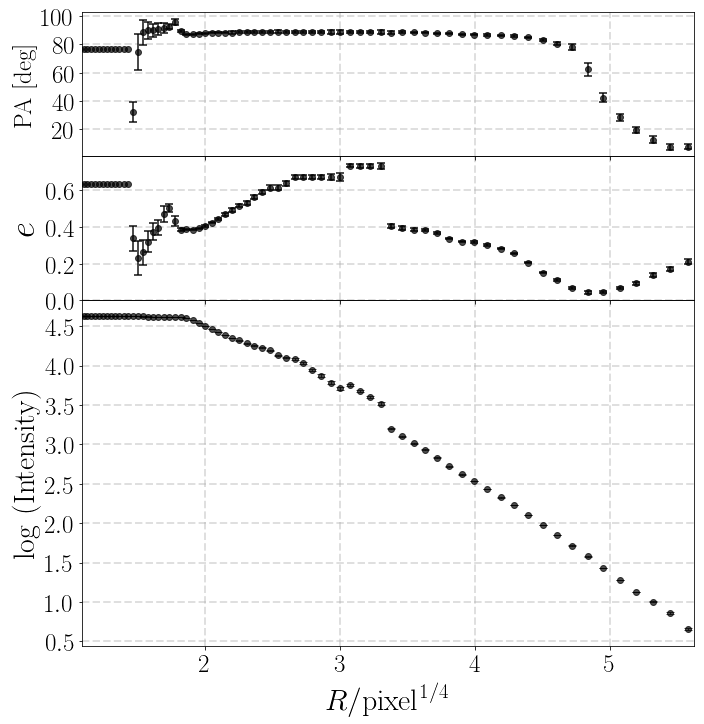

In [132]:
# Now we can take a look at the intensity profile and the elliptical, positional angle profile 

# The change of PA at large radius clearly suggests the transition between two component. 

# The ellipticity profile also shows a change from a highly elliptical structure (disk) to a round structure (bulge or halo)

_ = display_intensity_shape(ell_1, x_max=(1000 ** 0.25))

In [143]:
# We should not let everything to be free during the fitting once we understand the basic structure 
# of the galaxy. 

# Centeral coordinate 
# We need to fix the center, we can use an average value in the central region
x_cen_fix = np.nanmedian(ell_1['x0'][0:20])
y_cen_fix = np.nanmedian(ell_1['y0'][0:20])
print(x_cen_fix, y_cen_fix)

# Initial guess of axis ratio and position angle 
# Use more appropriate guesses for axis ratio and position angle based on the stage=1 result
ba_ini, pa_ini = 0.3, 90.0

# Initial radius of Ellipse fitting
sma_ini = 10.0

# Minimum and maximum radiuse of Ellipse fitting
sma_min, sma_max = 0.0, 1900.0

# Stepsize of Ellipse fitting
# Use larger stepsize to speed things up a little
step = 0.12

# Behaviour of Ellipse fitting
# Now we fix the center, but still let the shape of the isophote to change
stage = 2

# The rest parameters are the same 


# Start running Ellipse like this 
# Step 2 will take a few minutes
ell_2, bin_2 = galSBP.galSBP(img_fits, 
                             mask=msk_fits,
                             galX=x_cen_fix, galY=y_cen_fix,
                             galQ=ba_ini, galPA=pa_ini,
                             iniSma=sma_ini, 
                             minSma=sma_min, maxSma=sma_max,
                             pix=pix_scale, zpPhoto=zeropoint,
                             expTime=exptime, 
                             stage=stage,
                             ellipStep=step,
                             isophote=ISO, 
                             xttools=TBL, 
                             uppClip=upp_clip, lowClip=low_clip, 
                             nClip=n_clip, 
                             maxTry=3,
                             intMode=integrade_mode, 
                             saveOut=True, plMask=True,
                             verbose=True, savePng=False, 
                             updateIntens=False)

2039.304 1157.591
/Users/song/Downloads/m104_msk.fits -> temp_J41XX.fits.pl
/Users/song/Downloads/m104_msk.fits -> temp_J41XX.pl
----------------------------------------------------------------------------------------------------
###      galX, galY :  2039.304 1157.591
###      galR :  20.0
###      iniSma, maxSma :  10.0 1900.0
###      Stage :  2
###      Step :  0.12
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/song/Downloads/m104_img.fits
###      Input Image   : temp_J41XX.fits
###      Output Binary : /Users/so

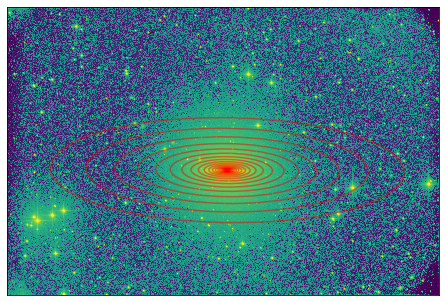

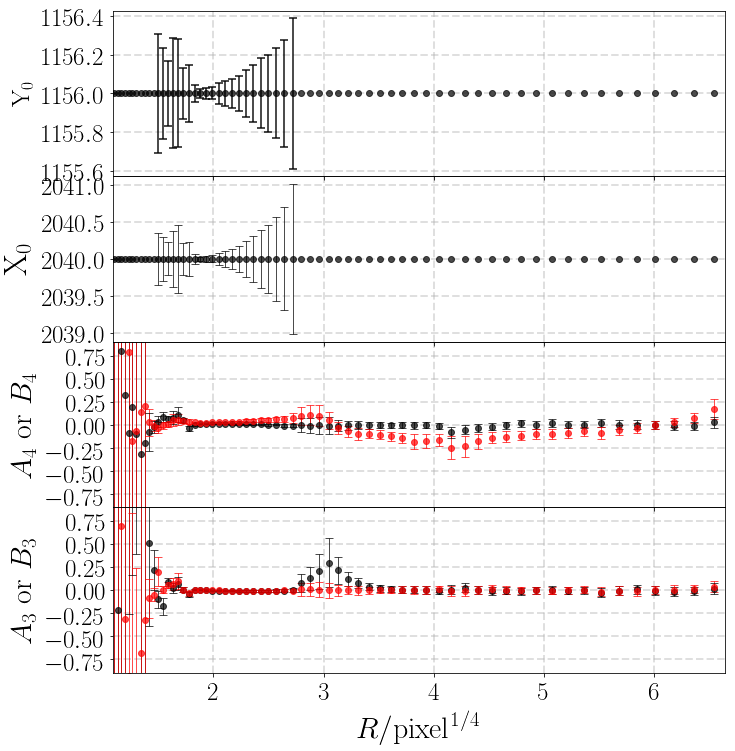

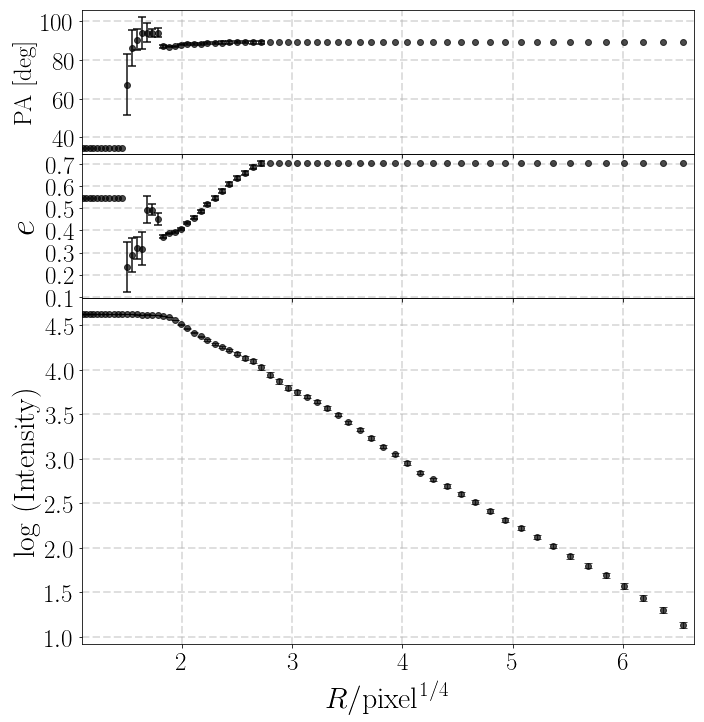

In [144]:
# Now we can see that the overall light in M104 is still dominated by the disk components

_ = display_isophote(img_test, ell_2)

_ = display_center_fourier(ell_2, x_max=(1950 ** 0.25))

_ = display_intensity_shape(ell_2, x_max=(1950 ** 0.25))